In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split

## Сбор данных

In [41]:
df = pd.read_csv('teams_matches_stats-2.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.sort_values(by = 'date', ignore_index = 'True', inplace = True)
y = list(map((lambda i: 1 if i == 'W' else 0), df['result']))
data = df.drop([ 'Opp Formation', 'Formation', 'Captain', 'Referee','result','time','game', 'day', 'season','GT', 'Gdiff'], axis = 1)

In [42]:
def getStats(team, date, df = data):
    srez = df[(df['team']== team)&(df['date'] < date)]
    if 0 < len(srez) < 10:
      stats = srez.drop(['team','date', 'opponent', 'venue'], axis = 1).sum()/len(srez)
    elif len(srez) >= 10:
      stats = srez.drop(['team','date', 'opponent', 'venue'], axis = 1)[-10:].sum()/10
    else:
      srez = df[(df['team']== team)&(df['date'] <= date)]
      stats = srez.drop(['team','date', 'opponent', 'venue'], axis = 1).sum()

    return stats.values.tolist()

In [43]:
def GetTrain(data):
  features = []
  for i in range(len(data)):
    team1 = getStats(data['team'][i], data['date'][i])
    team2 = getStats(data['opponent'][i], data['date'][i])
    diff = [a - b for a, b in zip(team1, team2)]
    features.append(diff)
  return features

In [44]:
feat_data = GetTrain(data)
x = pd.DataFrame(feat_data, columns=data.drop(['team', 'date', 'opponent', 'venue'], axis=1).columns)
x = pd.concat([x, data['venue']], axis=1)
num_cols = x.dtypes[(x.dtypes == 'int64') | (x.dtypes == 'float64')].index.tolist()
cat_cols = x.dtypes[x.dtypes == 'object'].index.tolist()

In [45]:
X_train, X_test, y_train, y_test = train_test_split(x, y,
                                                    train_size=0.8,
                                                    random_state=125)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                                    train_size=0.5,
                                                    random_state=125)
X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)

In [46]:
enc = OneHotEncoder(handle_unknown='ignore',drop = 'first', sparse_output = False)
encd = enc.fit_transform(X_train[['venue']])
encd_test = enc.transform(X_test[['venue']])
encd_val = enc.transform(X_val[['venue']])

one_hot_df = pd.DataFrame(encd, columns=enc.get_feature_names_out(['venue']))
one_hot_df_val = pd.DataFrame(encd_val, columns=enc.get_feature_names_out(['venue']))
one_hot_df_test = pd.DataFrame(encd_test, columns=enc.get_feature_names_out(['venue']))

X_train = pd.concat([X_train.drop(['venue'], axis = 1), one_hot_df], axis = 1)
X_val = pd.concat([X_val.drop(['venue'], axis = 1), one_hot_df_val], axis = 1)
X_test = pd.concat([X_test.drop(['venue'], axis = 1), one_hot_df_test], axis = 1)

In [47]:
normalizer = StandardScaler()
scaler = normalizer.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

In [48]:
X_train = torch.FloatTensor(X_train_norm)
y_train = torch.LongTensor(y_train)
X_val = torch.FloatTensor(X_val_norm)
y_val = torch.LongTensor(y_val)
X_test = torch.FloatTensor(X_test_norm)
y_test = torch.LongTensor(y_test)

In [54]:
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.batch = nn.BatchNorm1d(num_features=32)
        self.fc3 = nn.Linear(32, 2)
        self.relu = nn.GELU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(self.batch(x))
        return x

In [55]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [56]:
model = NeuralNet(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [57]:
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience = 5
trigger_times = 0

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Валидация
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())

    # Ранняя остановка
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    print(f'Epoch {epoch}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}')

Epoch 0: Train Loss = 0.7601, Val Loss = 0.7114
Epoch 1: Train Loss = 0.7342, Val Loss = 0.7067
Epoch 2: Train Loss = 0.7209, Val Loss = 0.7027
Epoch 3: Train Loss = 0.7125, Val Loss = 0.6991
Epoch 4: Train Loss = 0.6945, Val Loss = 0.6960
Epoch 5: Train Loss = 0.6897, Val Loss = 0.6934
Epoch 6: Train Loss = 0.6866, Val Loss = 0.6912
Epoch 7: Train Loss = 0.6754, Val Loss = 0.6892
Epoch 8: Train Loss = 0.6767, Val Loss = 0.6874
Epoch 9: Train Loss = 0.6728, Val Loss = 0.6858
Epoch 10: Train Loss = 0.6670, Val Loss = 0.6841
Epoch 11: Train Loss = 0.6618, Val Loss = 0.6825
Epoch 12: Train Loss = 0.6637, Val Loss = 0.6807
Epoch 13: Train Loss = 0.6612, Val Loss = 0.6788
Epoch 14: Train Loss = 0.6634, Val Loss = 0.6767
Epoch 15: Train Loss = 0.6562, Val Loss = 0.6745
Epoch 16: Train Loss = 0.6501, Val Loss = 0.6723
Epoch 17: Train Loss = 0.6546, Val Loss = 0.6699
Epoch 18: Train Loss = 0.6495, Val Loss = 0.6676
Epoch 19: Train Loss = 0.6515, Val Loss = 0.6654
Epoch 20: Train Loss = 0.6505,

In [58]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = accuracy_score(y_test, predicted)
    f1 = f1_score(y_test, predicted, average='macro')

print(f'Test Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

Test Accuracy: 0.6612, F1-Score: 0.6601


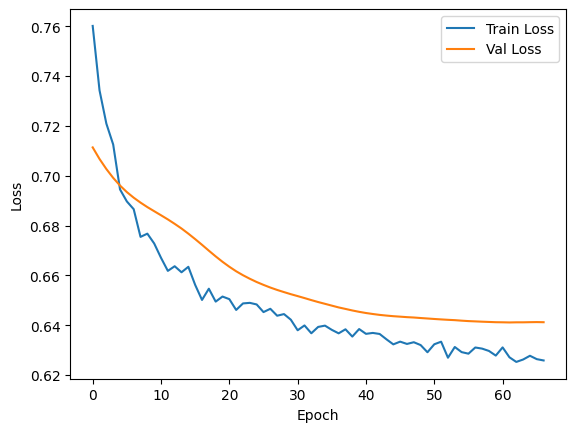

In [59]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Optuna

In [28]:
!pip install optuna -q

In [18]:
import optuna
from optuna.trial import TrialState

In [19]:
def define_model(trial, input_size):
    n_layers = trial.suggest_int('n_layers', 2, 5)
    layers = []
    in_features = input_size

    for i in range(n_layers):
        out_features = trial.suggest_int(f'n_units_layer_{i}', 64, 256, step=32)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.BatchNorm1d(out_features))
        layers.append(nn.GELU())
        dropout_rate = trial.suggest_float(f'dropout_layer_{i}', 0.1, 0.5)
        layers.append(nn.Dropout(dropout_rate))
        in_features = out_features

    layers.append(nn.Linear(in_features, 2))
    return nn.Sequential(*layers)

def objective(trial):
    model = define_model(trial, X_train.shape[1])
    criterion = nn.CrossEntropyLoss()

    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    n_epochs = trial.suggest_int('n_epochs', 50, 200)
    patience = 5
    best_val_loss = float('inf')
    trigger_times = 0

    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                break

    return best_val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=3600)  # 50 trials или 1 час

print("Лучшие гиперпараметры:")
best_params = study.best_params
for key, value in best_params.items():
    print(f"{key}: {value}")

final_model = define_model(optuna.trial.FixedTrial(best_params), X_train.shape[1])
optimizer = optim.AdamW(
    final_model.parameters(),
    lr=best_params['lr'],
    weight_decay=best_params['weight_decay']
)

for epoch in range(best_params['n_epochs']):
    final_model.train()
    optimizer.zero_grad()
    outputs = final_model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

[I 2025-06-10 16:34:46,945] A new study created in memory with name: no-name-32ac06dc-d607-4e94-b885-44e1aa386f09
[I 2025-06-10 16:35:52,088] Trial 0 finished with value: 0.6492549180984497 and parameters: {'n_layers': 5, 'n_units_layer_0': 128, 'dropout_layer_0': 0.23974866509059822, 'n_units_layer_1': 96, 'dropout_layer_1': 0.4259515024439521, 'n_units_layer_2': 224, 'dropout_layer_2': 0.24760856678949272, 'n_units_layer_3': 160, 'dropout_layer_3': 0.4100043560721812, 'n_units_layer_4': 128, 'dropout_layer_4': 0.4633923322139717, 'lr': 6.087843914555008e-05, 'weight_decay': 1.1120566449430665e-06, 'n_epochs': 139}. Best is trial 0 with value: 0.6492549180984497.
[I 2025-06-10 16:35:54,156] Trial 1 finished with value: 0.638554573059082 and parameters: {'n_layers': 2, 'n_units_layer_0': 224, 'dropout_layer_0': 0.3044438913018377, 'n_units_layer_1': 96, 'dropout_layer_1': 0.4821958353241861, 'lr': 0.0021759689170679003, 'weight_decay': 0.0004632967002755438, 'n_epochs': 113}. Best is t

Лучшие гиперпараметры:
n_layers: 2
n_units_layer_0: 256
dropout_layer_0: 0.27663508247609675
n_units_layer_1: 128
dropout_layer_1: 0.16359050379953352
lr: 0.0008497522139496691
weight_decay: 2.0760464369116264e-05
n_epochs: 113


In [23]:
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.batch = nn.BatchNorm1d(num_features=128)
        self.fc3 = nn.Linear(128, 2)
        self.relu = nn.GELU()
        self.dropout1 = nn.Dropout(0.28)
        self.dropout2 = nn.Dropout(0.16)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(self.batch(x))
        return x

In [24]:
model = NeuralNet(input_size=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00085, weight_decay=2e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [25]:
train_losses, val_losses = [], []
best_val_loss = float('inf')
patience = 5
trigger_times = 0

for epoch in range(113):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Валидация
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
        val_losses.append(val_loss.item())

    # Ранняя остановка
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    print(f'Epoch {epoch}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}')

Epoch 0: Train Loss = 0.8815, Val Loss = 0.6867
Epoch 1: Train Loss = 0.7118, Val Loss = 0.6739
Epoch 2: Train Loss = 0.7016, Val Loss = 0.6671
Epoch 3: Train Loss = 0.7116, Val Loss = 0.6636
Epoch 4: Train Loss = 0.7108, Val Loss = 0.6617
Epoch 5: Train Loss = 0.6895, Val Loss = 0.6612
Epoch 6: Train Loss = 0.6653, Val Loss = 0.6621
Epoch 7: Train Loss = 0.6632, Val Loss = 0.6638
Epoch 8: Train Loss = 0.6557, Val Loss = 0.6658
Epoch 9: Train Loss = 0.6576, Val Loss = 0.6669
Early stopping at epoch 10


In [26]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = accuracy_score(y_test, predicted)
    f1 = f1_score(y_test, predicted, average='macro')

print(f'Test Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}')

Test Accuracy: 0.6643, F1-Score: 0.6487


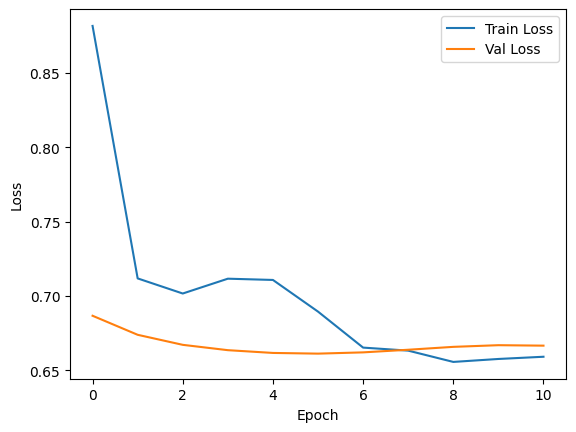

In [27]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()